# Part 1: Environment Setup & Dataset Preparation

In [ ]:
# -----------------------------
# 1. ENVIRONMENT SETUP
# -----------------------------

# We are using Google Colab to run this code.
# Reason: The model is heavy and benefits from GPU acceleration.
# In Colab, you can enable GPU:
# Go to: Runtime -> Change runtime type -> Set "Hardware Accelerator" = GPU.

# Install required libraries using pip.
# - tensorflow: Deep learning framework.
# - efficientnet: Pre-trained EfficientNet models for transfer learning.
# - scikit-learn: For data splitting, class weights, metrics.
# - pandas: Data manipulation & CSV handling.
# - matplotlib: Visualization (plots, charts, curves).
# - albumentations: For advanced image augmentation (optional).
!pip install -q tensorflow efficientnet scikit-learn pandas matplotlib albumentations

# Install optional explainability libraries.
# - tf-keras-vis: Visualization tools like Grad-CAM for CNNs.
# - tf-explain: Another explainability toolkit.
!pip install -q tf-keras-vis tf-explain

In [2]:
# -----------------------------
# 2. CHECK GPU AVAILABILITY
# -----------------------------

# Import required libraries.
import tensorflow as tf
import time, os

# Print TensorFlow version to confirm installation.
print("TF version:", tf.__version__)

# Check if a GPU is available.
# Deep learning models train much faster with GPUs.
print("GPU available:", tf.config.list_physical_devices('GPU'))

TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# -----------------------------
# 3. MOUNT GOOGLE DRIVE
# -----------------------------

# Google Drive is used to store the HAM10000 dataset and save model outputs.
# We will mount it so Colab can read/write files there.
from google.colab import drive

# This will prompt you to authorize access.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -----------------------------
# 4. DATASET SETUP
# -----------------------------

# The HAM10000 dataset can be downloaded from Kaggle:
# https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
# After downloading, upload it to your Google Drive.

# Provide the path to your dataset ZIP file in Drive.
ZIP_IN_DRIVE = "/content/drive/MyDrive/Coding/Cancer Analysis/HAM10000.zip"

# Local working directory inside Colab VM where we'll extract the dataset.
WORKDIR = "/content/ham10000"

# Create the working directory if it doesn't exist.
!mkdir -p $WORKDIR

# Unzip the dataset into the working directory.
!unzip -q "$ZIP_IN_DRIVE" -d $WORKDIR

# List the first 200 files to confirm successful extraction.
!ls -lah $WORKDIR | sed -n '1,200p'

total 128M
drwxr-xr-x 6 root root 4.0K Aug 24 11:15 .
drwxr-xr-x 1 root root 4.0K Aug 24 11:12 ..
drwxr-xr-x 2 root root 152K Aug 24 11:14 ham10000_images_part_1
drwxr-xr-x 2 root root 152K Aug 24 11:13 HAM10000_images_part_1
drwxr-xr-x 2 root root 160K Aug 24 11:15 ham10000_images_part_2
drwxr-xr-x 2 root root 160K Aug 24 11:13 HAM10000_images_part_2
-rw-r--r-- 1 root root 551K Oct  6  2019 HAM10000_metadata.csv
-rw-r--r-- 1 root root  30M Oct  6  2019 hmnist_28_28_L.csv
-rw-r--r-- 1 root root  88M Oct  6  2019 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root 2.5M Oct  6  2019 hmnist_8_8_L.csv
-rw-r--r-- 1 root root 7.2M Oct  6  2019 hmnist_8_8_RGB.csv


In [5]:
# -----------------------------
# 5. MERGE IMAGE FOLDERS
# -----------------------------

# The Kaggle ZIP usually contains two folders:
# - ham10000_images_part_1 → 5000 images
# - ham10000_images_part_2 → 5000 images
# We'll merge them into a single folder for easier training.

# Define the path for the merged images.
IMAGES = f"{WORKDIR}/HAM10000_images"

# Create the merged images directory.
!mkdir -p "$IMAGES"

# Copy images from both parts into the merged folder.
!cp $WORKDIR/ham10000_images_part_1/* "$IMAGES"/
!cp $WORKDIR/ham10000_images_part_2/* "$IMAGES"/
!cp $WORKDIR/HAM10000_images_part_1/* "$IMAGES"/
!cp $WORKDIR/HAM10000_images_part_2/* "$IMAGES"/

# Count total images to ensure merge worked correctly.
!echo "Total images merged:" && ls -1 "$IMAGES" | wc -l

Total images merged:
10015


# Part 2: Exploratory Data Analysis

In this part, we’ll focus on loading the metadata CSV, analyzing the dataset, and understanding the image labels.

In [6]:
# -----------------------------
# 6. LOAD HAM10000 METADATA
# -----------------------------

import pandas as pd  # Pandas is used for working with CSVs and dataframes

# Path to metadata CSV file extracted earlier
csv_path = "/content/ham10000/HAM10000_metadata.csv"

# Read CSV into a Pandas DataFrame
df = pd.read_csv(csv_path)

# Peek at the first 5 rows to understand the structure of the data
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


	Important columns:
	•	image_id → unique image filename (without .jpg)
	•	dx → diagnosis label (e.g., mel, nv, bkl)
	•	age → patient age
	•	sex → patient gender
	•	localization → body site of lesion
	•	lesion_id → groups images of the same lesion

In [9]:
# -----------------------------
# 7. BASIC DATASET INFO
# -----------------------------

# Count total number of images
print("\nNumber of rows (images):", len(df))

# Display all column names for reference
print("Columns available:", list(df.columns))


Number of rows (images): 10015
Columns available: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


In [7]:
# -----------------------------
# 8. CLASS DISTRIBUTION
# -----------------------------

# Count how many images belong to each diagnosis label (dx column)
print("\nClass distribution (counts):")
print(df['dx'].value_counts())

# Calculate percentage of images in each class
print("\nClass distribution (percent):")
print(df['dx'].value_counts(normalize=True) * 100)


Class distribution (counts):
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Class distribution (percent):
dx
nv       66.949576
mel      11.113330
bkl      10.973540
bcc       5.132302
akiec     3.265102
vasc      1.417873
df        1.148278
Name: proportion, dtype: float64


HAM10000 has 7 classes:
 akiec, bcc, bkl, df, nv, mel, vasc

- The dataset is imbalanced → e.g., “nv” (common mole) has thousands of images, but “mel” (melanoma) has fewer.
- We’ll use class weights later to fix imbalance.

In [8]:
# -----------------------------
# 9. UNIQUE LESIONS & PATIENTS
# -----------------------------

# Some patients have multiple images of the same lesion.
# We check how many unique lesions exist in the dataset.
if 'lesion_id' in df.columns:
    print("\nUnique lesions:", df['lesion_id'].nunique())

# Check unique patients if available
if 'patient_id' in df.columns:
    print("Unique patients:", df['patient_id'].nunique() if df['patient_id'].notna().any() else "N/A")


Unique lesions: 7470


Why this matters:

If we split train/validation randomly without grouping by lesion_id,
images of the same lesion might end up in both sets → data leakage.
We’ll handle this later using GroupShuffleSplit.

In [11]:
# -----------------------------
# 11. AGE, SEX, BODY LOCATION
# -----------------------------

# Check patient age statistics
if 'age' in df.columns:
    print("\nAge stats:")
    print(df['age'].describe())

# Gender distribution (male vs female)
if 'sex' in df.columns:
    print("\nSex distribution:")
    print(df['sex'].value_counts())

# Where on the body the lesion images are located
if 'localization' in df.columns:
    print("\nBody site distribution (top 10):")
    print(df['localization'].value_counts().head(10))


Age stats:
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

Sex distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Body site distribution (top 10):
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
Name: count, dtype: int64


# Part 3 – Dataset preparation & splitting

Now that we understand the dataset, in Part 3 we’ll annotate the model preparation code:

	•	Setting constants and hyperparameters
	•	Mapping labels to integers
	•	Splitting dataset into train/validation safely
	•	Generating full image paths

This part is critical before we start building the TensorFlow data pipeline.

In [12]:
# -----------------------------
# 12. CONSTANTS & CONFIGURATION
# -----------------------------

import random
import numpy as np
import pandas as pd

# Set a random SEED for reproducibility.
# This ensures the same random operations give the same results each time.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Image size: EfficientNetB0 expects 224x224 images.
IMG_SIZE = 224

# Number of images processed in one batch during training.
BATCH_SIZE = 32

# Number of times the model sees the dataset during training.
EPOCHS = 25

# Number of target classes (7 skin disease categories).
NUM_CLASSES = 7

# Optimize dataset loading using parallel threads.
AUTOTUNE = tf.data.AUTOTUNE

# Directory where images are stored.
DATA_DIR = "/content/ham10000/HAM10000_images"

# Metadata CSV file path.
METADATA_CSV = "/content/ham10000/HAM10000_metadata.csv"

In [13]:
# -----------------------------
# 13. LOAD METADATA AGAIN
# -----------------------------

import os
from sklearn.model_selection import GroupShuffleSplit

# Load the CSV again to ensure we have a fresh dataframe.
df = pd.read_csv(METADATA_CSV)

print("Columns:", df.columns.tolist())
print("Total rows:", len(df))

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
Total rows: 10015


In [14]:
# -----------------------------
# 14. CREATE FULL IMAGE PATHS
# -----------------------------

# The image filenames are in the 'image_id' column without the ".jpg" extension.
# We construct the full file path for each image.
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(DATA_DIR, x + ".jpg"))

# Check if any image files are missing from the dataset.
missing = (~df['image_path'].apply(os.path.exists)).sum()
print("Missing image files:", missing)

Missing image files: 0


In [15]:
# -----------------------------
# 15. MAP DIAGNOSIS → NUMERIC LABELS
# -----------------------------

# Classes as per HAM10000 dataset (alphabetical order)
CLASS_NAMES = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']

# Create a mapping: label name → label index (e.g., 'nv' → 4)
label2idx = {c: i for i, c in enumerate(CLASS_NAMES)}

# Apply mapping to create a numeric 'label_idx' column in the dataframe.
df['label_idx'] = df['dx'].map(label2idx)

print(df[['dx', 'label_idx']].head())

    dx  label_idx
0  bkl          2
1  bkl          2
2  bkl          2
3  bkl          2
4  bkl          2


In [16]:
# -----------------------------
# 16. SAFE TRAIN/VALIDATION SPLIT
# -----------------------------

# We want to ensure that images from the SAME lesion/patient do NOT end up in both train and validation sets.
# Otherwise, the model may "cheat" by memorizing features of the same lesion.

# Prefer splitting by 'lesion_id' (if available), else 'patient_id', else fallback to 'image_id'.
group_col = None
for c in ('lesion_id', 'patient_id'):
    if c in df.columns:
        group_col = c
        break

# If neither column exists, fallback to image_id (less ideal).
if group_col is None:
    print("⚠️ No lesion_id or patient_id found, splitting by image_id (less ideal).")
    df['group_id'] = df['image_id']
else:
    df['group_id'] = df[group_col].astype(str)

# Use GroupShuffleSplit from scikit-learn.
# Ensures groups stay together when splitting.
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=SEED)
# Why We Use GroupShuffleSplit
# •	If one patient has multiple images, we must keep all their images together.
# •	Otherwise, validation accuracy would look artificially high.
# •	Using GroupShuffleSplit ensures zero data leakage

# Split into training and validation sets.
train_idx, val_idx = next(gss.split(df, groups=df['group_id']))
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

# Show sizes of resulting splits.
print("Train size:", len(train_df), "Val size:", len(val_df))
print(train_df.head())

Train size: 7991 Val size: 2024
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  label_idx     group_id  
0  /content/ham10000/HAM10000_images/ISIC_0027419...          2  HAM_0000118  
1  /content/ham10000/HAM10000_images/ISIC_0025030...          2  HAM_0000118  
2  /content/ham10000/HAM10000_images/ISIC_0026769...          2  HAM_0002730  
3  /content/ham10000/HAM10000_images/ISIC_0025661...          2  HAM_0002730  
4  /content/ham10000/HAM10000_images/ISIC_0031633...          2  HAM_0001466  


# Part 4 – TensorFlow data pipeline & augmentation
In Part 4, we’ll annotate the code for:

	•	Preprocessing images for TensorFlow
	•	Data augmentation (random flips, brightness, etc.)
	•	Building tf.data.Dataset pipelines for training and validation
	•	Checking batch shapes before feeding them into the model

This step is important because it optimizes data loading and ensures GPU training runs fast and efficiently.

In [17]:
# -----------------------------
# 17. TENSORFLOW CONSTANTS
# -----------------------------

import tensorflow as tf

# Image size for EfficientNetB0 model
IMG_SIZE = 224

# Number of images per batch
BATCH_SIZE = 32

# Number of classes in HAM10000 dataset
NUM_CLASSES = len(CLASS_NAMES)

# AUTOTUNE allows TensorFlow to optimize performance automatically
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
# -----------------------------
# 18. IMAGE PREPROCESSING FUNCTION
# -----------------------------

def preprocess_image(image_path, label_idx):
    """
    Preprocesses a single image for EfficientNetB0.
    Steps:
    1. Read the image from disk
    2. Decode JPEG to tensor
    3. Resize to 224x224 (EfficientNetB0 input size)
    4. Normalize using EfficientNet preprocessing
    5. One-hot encode the label
    """

    # Step 1: Read image file as bytes
    image = tf.io.read_file(image_path)

    # Step 2: Decode image into RGB tensor
    image = tf.image.decode_jpeg(image, channels=3)

    # Step 3: Resize image to required size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Step 4: Normalize image using EfficientNet preprocessing
    # This scales pixel values to the range [-1, 1]
    image = tf.keras.applications.efficientnet.preprocess_input(image)

    # Step 5: Convert class label to one-hot vector
    label = tf.one_hot(label_idx, NUM_CLASSES)

    return image, label

In [20]:
# -----------------------------
# 19. DATA AUGMENTATION FUNCTION
# -----------------------------

def augment(image, label):
    """
    Augments training images to improve generalization.
    Includes:
    - Random horizontal flip
    - Random vertical flip
    - Random brightness adjustment
    """
    image = tf.image.random_flip_left_right(image)  # Flip horizontally
    image = tf.image.random_flip_up_down(image)    # Flip vertically
    image = tf.image.random_brightness(image, 0.1) # Adjust brightness ±10%
    return image, label
# Medical datasets are small. Augmentation artificially increases data diversity → helps avoid overfitting.

In [21]:
# -----------------------------
# 20. CONVERT DATAFRAME → TENSORFLOW DATASET
# -----------------------------

def df_to_dataset(df, shuffle=True, augment_fn=None):
    """
    Converts a Pandas DataFrame into a TensorFlow dataset.
    Steps:
    1. Extract image paths & labels
    2. Create TensorFlow dataset
    3. Apply preprocessing
    4. Apply optional augmentation
    5. Batch & prefetch for performance
    """

    # Step 1: Get arrays of image paths & labels
    paths = df['image_path'].values
    labels = df['label_idx'].values

    # Step 2: Create a dataset from arrays
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Step 3: Shuffle dataset for randomness (only for training)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42)

    # Step 4: Apply image preprocessing function
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    # Step 5: Apply data augmentation if provided
    if augment_fn is not None:
        ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

    # Step 6: Batch & prefetch for efficient GPU utilization
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return ds

In [22]:
# -----------------------------
# 21. CREATE TRAINING & VALIDATION DATASETS
# -----------------------------

# Build training dataset with augmentation
train_ds = df_to_dataset(train_df, shuffle=True, augment_fn=augment)

# Build validation dataset (NO augmentation)
val_ds   = df_to_dataset(val_df, shuffle=False)

In [23]:
# -----------------------------
# 22. CHECK SAMPLE BATCH
# -----------------------------

# Inspect one batch of images & labels
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)   # Expected: (32, 224, 224, 3)
    print("Label batch shape:", labels.shape)   # Expected: (32, 7)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 7)


# Part 5 - Model building & training preparation

In Part 5, we’ll annotate the model creation & training setup:

	•	Build EfficientNetB0 base model
	•	Add custom classification head
	•	Set up callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
	•	Handle class imbalance using class weights
	•	Prepare model compilation before training

In [27]:
# -----------------------------
# 23. IMPORT MODEL COMPONENTS
# -----------------------------

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#	•	layers → Used to add model layers (Pooling, Dense, Dropout, etc.)
#	•	models → For creating the overall model architecture.
#	•	ModelCheckpoint → Saves the best model during training.
#	•	EarlyStopping → Stops training if the model stops improving.
#	•	ReduceLROnPlateau → Reduces the learning rate if validation score stops improving.

In [28]:
# -----------------------------
# 24. CREATE EFFICIENTNETB0 BASE MODEL
# -----------------------------

base = tf.keras.applications.EfficientNetB0(
    include_top=False,                 # Do not include the default classification layer
    input_shape=(IMG_SIZE, IMG_SIZE, 3), # Image size (224x224x3)
    weights="imagenet"                # Use pre-trained weights from ImageNet
)
# Why EfficientNetB0?
#	•	Lightweight & efficient for image classification.
#	•	Pre-trained on ImageNet → learns faster.
#	•	Freezing layers first → avoids destroying pre-trained features.

# Initially, freeze the base model weights
base.trainable = False

In [30]:
# -----------------------------
# 25. ADD CUSTOM HEAD ON TOP OF BASE MODEL
# -----------------------------

# Input layer for 224x224 RGB images
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Pass inputs through EfficientNet base model
x = base(inputs, training=False)

# Pool the output (reduces dimensions, retains important features)
x = layers.GlobalAveragePooling2D()(x)

# Add dropout for regularization (reduces overfitting)
# Dropout(0.3) → Randomly “drops” 30% of neurons → avoids overfitting.
x = layers.Dropout(0.3)(x)

# Final classification layer: 7 outputs for 7 skin disease categories
# softmax → Converts outputs into probabilities for 7 classes
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Create the full model
model = models.Model(inputs, outputs)

In [31]:
# -----------------------------
# 26. SETUP TRAINING CALLBACKS
# -----------------------------

# Save the best model based on validation AUC
checkpoint = ModelCheckpoint(
    "/content/best_model.h5",   # Save path
    monitor="val_auc",          # Monitor validation AUC score
    mode="max",                 # Higher AUC is better
    save_best_only=True,        # Keep only the best model
    verbose=1
)

# Stop training early if AUC does not improve for 5 epochs
earlystop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if performance plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,      # Halve the learning rate
    patience=2,      # Wait 2 epochs before reducing
    verbose=1
)

# Bundle all callbacks together
callbacks = [checkpoint, earlystop, reduce_lr]

In [32]:
# HAM10000 dataset is heavily imbalanced:
#	•	nv → ~6,700 images
#	•	mel → ~1,100 images
#	•	Other classes → much fewer
# Without class weights, the model would ignore rare classes like melanoma.
# We want high recall for melanoma detection → missing one can be fatal.
# In this section we will calculate class weight and use it to manage class imbalance. Assign higher weights to minority classes → model focuses on them more.
# -----------------------------
# 27. COMPUTE CLASS WEIGHTS
# -----------------------------

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels from training data
y_train = train_df['label_idx'].values

# Compute balanced weights = total_samples / (num_classes * samples_per_class)
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(NUM_CLASSES),
    y=y_train
)

# Convert to dictionary: {class_index: weight}
class_weights = dict(enumerate(weights))

print("Class weights:", class_weights)

Class weights: {0: np.float64(4.390659340659341), 1: np.float64(2.6923854447439353), 2: np.float64(1.333611481975968), 3: np.float64(11.76877761413844), 4: np.float64(0.21262272836122714), 5: np.float64(1.3016777976869196), 6: np.float64(10.57010582010582)}


In [34]:
# -----------------------------
# 28. COMPILE MODEL - STAGE 1
# -----------------------------

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Learning rate = 0.0001
    loss="categorical_crossentropy",          # Suitable for multi-class classification
    metrics=[
        "accuracy",                           # Overall accuracy.
        tf.keras.metrics.AUC(name="auc", multi_label=True),   # Area Under Curve. Captures how well model separates classes
        tf.keras.metrics.Precision(name="precision"),         # Precision score
        tf.keras.metrics.Recall(name="recall")                # Recall score. Most important metrice for healthcare models
    ]
)

# Part 6 – Training the model in two stages

	•	Stage 1 → Train only the custom classification head (EfficientNet frozen)
	•	Stage 2 → Unfreeze the last layers of EfficientNet and fine-tune them at a lower learning rate
	•	Use callbacks + class weights to handle imbalance and prevent overfitting

In [35]:
# -----------------------------
# 29. TRAIN MODEL - STAGE 1
# -----------------------------

history_stage1 = model.fit(
    train_ds,                 # Training dataset
    validation_data=val_ds,   # Validation dataset
    epochs=12,                # Train for 12 epochs initially
    callbacks=callbacks,      # Checkpoints, LR scheduler, early stopping. monitor val_auc to save the best model and adjust learning rate
    class_weight=class_weights # Handle dataset imbalance. ensure rare melanoma cases are not ignored
)

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1659 - auc: 0.5153 - loss: 1.9803 - precision: 0.0526 - recall: 2.7447e-04
Epoch 1: val_auc improved from -inf to 0.69265, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 244ms/step - accuracy: 0.1661 - auc: 0.5155 - loss: 1.9803 - precision: 0.0529 - recall: 2.7587e-04 - val_accuracy: 0.3854 - val_auc: 0.6926 - val_loss: 1.7746 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3482 - auc: 0.6636 - loss: 1.8023 - precision: 0.5348 - recall: 0.0046
Epoch 2: val_auc improved from 0.69265 to 0.78154, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3483 - auc: 0.6636 - loss: 1.8023 - precision: 0.5353 - recall: 0.0046 - val_accuracy: 0.4817 - val_auc: 0.7815 - val_loss: 1.6268 - val_precision: 1.0000 - val_recall: 0.0035 - learning_rate: 1.0000e-04
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4357 - auc: 0.7430 - loss: 1.6265 - precision: 0.7637 - recall: 0.0259
Epoch 3: val_auc improved from 0.78154 to 0.81894, saving model to /content/best_model.h5



Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4357 - auc: 0.7431 - loss: 1.6267 - precision: 0.7638 - recall: 0.0259 - val_accuracy: 0.5069 - val_auc: 0.8189 - val_loss: 1.5435 - val_precision: 0.9318 - val_recall: 0.0203 - learning_rate: 1.0000e-04
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4787 - auc: 0.7836 - loss: 1.5774 - precision: 0.8055 - recall: 0.0487
Epoch 4: val_auc improved from 0.81894 to 0.83165, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4787 - auc: 0.7837 - loss: 1.5775 - precision: 0.8056 - recall: 0.0488 - val_accuracy: 0.5094 - val_auc: 0.8316 - val_loss: 1.5060 - val_precision: 0.9294 - val_recall: 0.0390 - learning_rate: 5.0000e-05
Epoch 5/12
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4836 - auc: 0.8006 - loss: 1.6109 - precision: 0.8340 - recall: 0.0731
Epoch 5: val_auc improved from 0.83165 to 0.84264, saving model to /content/best_model.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4837 - auc: 0.8007 - loss: 1.6103 - precision: 0.8342 - recall: 0.0733 - val_accuracy: 0.5316 - val_auc: 0.8426 - val_loss: 1.4501 - val_precision: 0.9390 - val_recall: 0.0761 - learning_rate: 5.0000e-05
Epoch 6/12
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5055 - auc: 0.8154 - loss: 1.5174 - precision: 0.8574 - recall: 0.1029
Epoch 6: val_auc improved from 0.84264 to 0.84628, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5055 - auc: 0.8154 - loss: 1.5175 - precision: 0.8574 - recall: 0.1030 - val_accuracy: 0.5326 - val_auc: 0.8463 - val_loss: 1.4466 - val_precision: 0.9205 - val_recall: 0.0800 - learning_rate: 2.5000e-05
Epoch 7/12
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5211 - auc: 0.8257 - loss: 1.4875 - precision: 0.8577 - recall: 0.1143
Epoch 7: val_auc improved from 0.84628 to 0.84997, saving model to /content/best_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5210 - auc: 0.8257 - loss: 1.4877 - precision: 0.8576 - recall: 0.1144 - val_accuracy: 0.5341 - val_auc: 0.8500 - val_loss: 1.4289 - val_precision: 0.9314 - val_recall: 0.0939 - learning_rate: 2.5000e-05
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5165 - auc: 0.8204 - loss: 1.5173 - precision: 0.8649 - recall: 0.1178
Epoch 8: val_auc improved from 0.84997 to 0.85140, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5164 - auc: 0.8204 - loss: 1.5172 - precision: 0.8649 - recall: 0.1178 - val_accuracy: 0.5351 - val_auc: 0.8514 - val_loss: 1.4239 - val_precision: 0.9296 - val_recall: 0.0978 - learning_rate: 1.2500e-05
Epoch 9/12
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5055 - auc: 0.8183 - loss: 1.4762 - precision: 0.8388 - recall: 0.1188
Epoch 9: val_auc improved from 0.85140 to 0.85321, saving model to /content/best_model.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5056 - auc: 0.8184 - loss: 1.4764 - precision: 0.8390 - recall: 0.1189 - val_accuracy: 0.5366 - val_auc: 0.8532 - val_loss: 1.4151 - val_precision: 0.9267 - val_recall: 0.1062 - learning_rate: 1.2500e-05
Epoch 10/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5150 - auc: 0.8293 - loss: 1.4565 - precision: 0.8268 - recall: 0.1200
Epoch 10: val_auc improved from 0.85321 to 0.85379, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5150 - auc: 0.8293 - loss: 1.4565 - precision: 0.8268 - recall: 0.1201 - val_accuracy: 0.5375 - val_auc: 0.8538 - val_loss: 1.4116 - val_precision: 0.9250 - val_recall: 0.1097 - learning_rate: 6.2500e-06
Epoch 11/12
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5301 - auc: 0.8406 - loss: 1.4059 - precision: 0.8413 - recall: 0.1293
Epoch 11: val_auc improved from 0.85379 to 0.85436, saving model to /content/best_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5301 - auc: 0.8405 - loss: 1.4064 - precision: 0.8413 - recall: 0.1293 - val_accuracy: 0.5356 - val_auc: 0.8544 - val_loss: 1.4104 - val_precision: 0.9218 - val_recall: 0.1107 - learning_rate: 6.2500e-06
Epoch 12/12
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5308 - auc: 0.8386 - loss: 1.4310 - precision: 0.8594 - recall: 0.1304
Epoch 12: val_auc improved from 0.85436 to 0.85474, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5307 - auc: 0.8385 - loss: 1.4312 - precision: 0.8594 - recall: 0.1304 - val_accuracy: 0.5380 - val_auc: 0.8547 - val_loss: 1.4080 - val_precision: 0.9190 - val_recall: 0.1122 - learning_rate: 3.1250e-06
Restoring model weights from the end of the best epoch: 12.


In [36]:
# -----------------------------
# 30. UNFREEZE LAST 20 LAYERS FOR FINE-TUNING
# -----------------------------

# Make the base model trainable
base.trainable = True

# Freeze all layers except the last 20
for layer in base.layers[:-20]:
    layer.trainable = False

In [37]:
# -----------------------------
# 31. RE-COMPILE MODEL FOR STAGE 2
# -----------------------------

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", multi_label=True),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [38]:
# -----------------------------
# 32. TRAIN MODEL - STAGE 2
# -----------------------------

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                # Train for longer now since we unfreeze layers
    callbacks=callbacks,      # Use same callbacks as before
    class_weight=class_weights
)
#	•	Stage 2 fine-tunes the EfficientNet layers on our specific dataset.
#	•	Since EfficientNet was trained on ImageNet (general images), this step adapts it for skin lesion classification.
#	•	Again, we monitor AUC, not accuracy, since the dataset is imbalanced.

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2610 - auc: 0.7475 - loss: 1.6543 - precision: 0.2826 - recall: 0.0166
Epoch 1: val_auc did not improve from 0.85474
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.2611 - auc: 0.7476 - loss: 1.6542 - precision: 0.2828 - recall: 0.0166 - val_accuracy: 0.3775 - val_auc: 0.8229 - val_loss: 1.6817 - val_precision: 0.3630 - val_recall: 0.0242 - learning_rate: 1.0000e-05
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3197 - auc: 0.8019 - loss: 1.5513 - precision: 0.3052 - recall: 0.0233
Epoch 2: val_auc did not improve from 0.85474
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.3198 - auc: 0.8020 - loss: 1.5512 - precision: 0.3053 - recall: 0.0233 - val_accuracy: 0.3913 - val_auc: 0.8268 - val_loss: 1.6541 - val_precision: 0.3353 - val_recall: 0.0277 - learning_rate: 1.0000e-05
Epoch 3/20
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3769 - auc: 0.8304 - loss: 1.4464 - precisi


Epoch 9: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4636 - auc: 0.8579 - loss: 1.2653 - precision: 0.5816 - recall: 0.0888 - val_accuracy: 0.4832 - val_auc: 0.8550 - val_loss: 1.4754 - val_precision: 0.5627 - val_recall: 0.0954 - learning_rate: 1.2500e-06
Epoch 10/20
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4852 - auc: 0.8658 - loss: 1.3053 - precision: 0.6170 - recall: 0.0981
Epoch 10: val_auc improved from 0.85497 to 0.85581, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4852 - auc: 0.8658 - loss: 1.3052 - precision: 0.6169 - recall: 0.0981 - val_accuracy: 0.4842 - val_auc: 0.8558 - val_loss: 1.4650 - val_precision: 0.5788 - val_recall: 0.0998 - learning_rate: 6.2500e-07
Epoch 11/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4811 - auc: 0.8619 - loss: 1.2734 - precision: 0.5889 - recall: 0.0986
Epoch 11: val_auc improved from 0.85581 to 0.85611, saving model to /content/best_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4811 - auc: 0.8620 - loss: 1.2735 - precision: 0.5889 - recall: 0.0986 - val_accuracy: 0.4862 - val_auc: 0.8561 - val_loss: 1.4648 - val_precision: 0.5813 - val_recall: 0.1042 - learning_rate: 6.2500e-07
Epoch 12/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4729 - auc: 0.8576 - loss: 1.3079 - precision: 0.6050 - recall: 0.1044
Epoch 12: val_auc improved from 0.85611 to 0.85614, saving model to /content/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4729 - auc: 0.8576 - loss: 1.3078 - precision: 0.6050 - recall: 0.1044 - val_accuracy: 0.4872 - val_auc: 0.8561 - val_loss: 1.4628 - val_precision: 0.5788 - val_recall: 0.1052 - learning_rate: 3.1250e-07
Epoch 13/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4836 - auc: 0.8661 - loss: 1.2374 - precision: 0.6146 - recall: 0.1050
Epoch 13: val_auc improved from 0.85614 to 0.85681, saving model to /content/best_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4836 - auc: 0.8661 - loss: 1.2378 - precision: 0.6147 - recall: 0.1050 - val_accuracy: 0.4881 - val_auc: 0.8568 - val_loss: 1.4579 - val_precision: 0.5858 - val_recall: 0.1062 - learning_rate: 3.1250e-07
Epoch 14/20
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4765 - auc: 0.8601 - loss: 1.2978 - precision: 0.6145 - recall: 0.1081
Epoch 14: val_auc did not improve from 0.85681
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4764 - auc: 0.8602 - loss: 1.2977 - precision: 0.6143 - recall: 0.1081 - val_accuracy: 0.4881 - val_auc: 0.8561 - val_loss: 1.4663 - val_precision: 0.5753 - val_recall: 0.1038 - learning_rate: 1.5625e-07
Epoch 15/20
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4847 - auc: 0.8629 - loss: 1.3048 - precision: 0.5779 - recall: 0.0956
Epoch 15: val_auc did not improve from 0.85681

Epoch 15: ReduceLROnPlateau re

In [39]:
# -----------------------------
# 33. CHECK DATASET BATCHES
# -----------------------------

print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))

Train batches: 250
Val batches: 64


# Part 7 – Model evaluation & metrics

In [40]:
# -----------------------------
# 34. IMPORT EVALUATION LIBRARIES
# -----------------------------

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
#	•	classification_report → Gives precision, recall, and F1-score for each class.
#	•	confusion_matrix → Helps visualize true positives, false positives, etc.
#	•	roc_auc_score → Computes overall AUC score for multi-class classification.

In [41]:
# -----------------------------
# 35. GET MODEL PREDICTIONS
# -----------------------------

y_true, y_pred, y_prob = [], [], []

# Loop through validation dataset batch by batch
for x_batch, y_batch in val_ds:
    # Get prediction probabilities for this batch
    probs = model.predict(x_batch, verbose=0)

    # Pick the class with the highest probability
    preds = np.argmax(probs, axis=1)

    # Append true labels
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

    # Append predicted labels
    y_pred.extend(preds)

    # Store full probability vectors for AUC calculation later
    y_prob.extend(probs)

# Convert lists into NumPy arrays for metric calculations
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

In [42]:
# -----------------------------
# 36. PRINT CLASSIFICATION REPORT
# -----------------------------

print("🔹 Classification Report")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
#	•	Precision → How many predicted positives are correct.
#	•	Recall (Sensitivity) → How many actual positives we detected.
#	•	F1-score → Balance between precision & recall.

🔹 Classification Report
              precision    recall  f1-score   support

       akiec       0.17      0.61      0.26        67
         bcc       0.25      0.43      0.31        90
         bkl       0.38      0.21      0.27       243
          df       0.06      0.39      0.10        18
          nv       0.96      0.53      0.68      1336
         mel       0.26      0.47      0.34       236
        vasc       0.16      0.91      0.27        34

    accuracy                           0.49      2024
   macro avg       0.32      0.51      0.32      2024
weighted avg       0.73      0.49      0.55      2024



In [43]:
# -----------------------------
# 37. PRINT CONFUSION MATRIX
# -----------------------------

print("🔹 Confusion Matrix")
print(confusion_matrix(y_true, y_pred))
# How to Read It:
#	•	Rows → True labels
#	•	Columns → Predicted labels
#	•	Diagonal values → Correct predictions.
#	•	Off-diagonal values → Misclassifications.

🔹 Confusion Matrix
[[ 41  15   2   1   0   6   2]
 [ 25  39   2  12   1   4   7]
 [ 78  20  51  21   7  58   8]
 [  5   2   1   7   1   2   0]
 [ 63  60  61  69 707 246 130]
 [ 35  21  18  10  22 112  18]
 [  0   1   0   1   1   0  31]]


In [45]:
# -----------------------------
# 38. CALCULATE ROC-AUC SCORE
# -----------------------------

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class="ovr")
    print(f"🔹 Overall ROC-AUC: {auc_score:.4f}")
except Exception as e:
    print("ROC-AUC calculation failed:", e)
#	•	multi_class="ovr" → One-vs-Rest strategy for multi-class problems.
#	•	AUC close to 1.0 = excellent classifier.
#	•	AUC close to 0.5 = random guessing.

🔹 Overall ROC-AUC: 0.8568


In [46]:
# -----------------------------
# 39. MELANOMA PRECISION-RECALL CURVE
# -----------------------------

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predictions again for precision-recall analysis
y_true, y_prob = [], []
for x_batch, y_batch in val_ds:
    probs = model.predict(x_batch, verbose=0)
    y_prob.extend(probs)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

# Convert to arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Get the index of melanoma class
mel_idx = CLASS_NAMES.index("mel")

# Create binary labels: 1 = melanoma, 0 = non-melanoma
y_true_mel = (y_true == mel_idx).astype(int)
y_prob_mel = y_prob[:, mel_idx]

# Compute precision-recall curve for melanoma
precision, recall, thresholds = precision_recall_curve(y_true_mel, y_prob_mel)

# Calculate average precision score (area under PR curve)
ap_score = average_precision_score(y_true_mel, y_prob_mel)
print(f"🔹 Melanoma PR-AUC: {ap_score:.4f}")

🔹 Melanoma PR-AUC: 0.2765


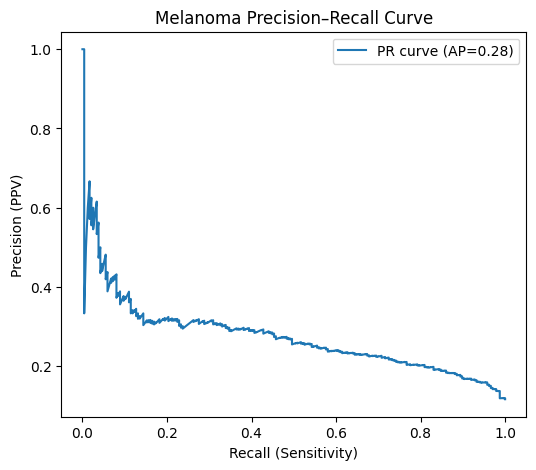

In [47]:
# -----------------------------
# 40. PLOT MELANOMA PR CURVE
# -----------------------------

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR curve (AP={ap_score:.2f})")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Melanoma Precision–Recall Curve")
plt.legend()
plt.show()

#	A good model has high recall (detects most melanomas) and high precision (fewer false alarms).
#	For healthcare, recall is usually prioritized — we’d rather flag extra cases than miss melanomas.

# Part 8 – Training visualization & model explainability

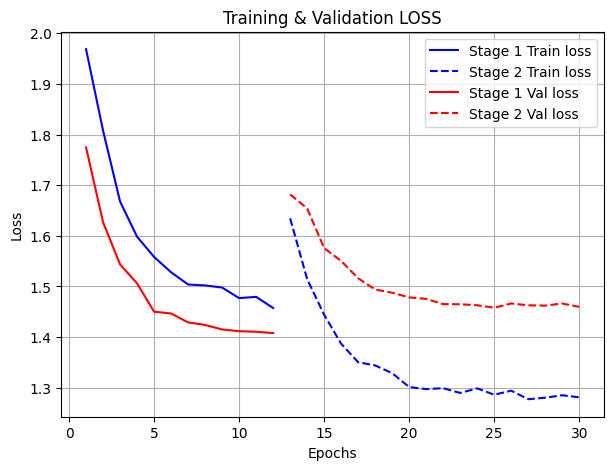

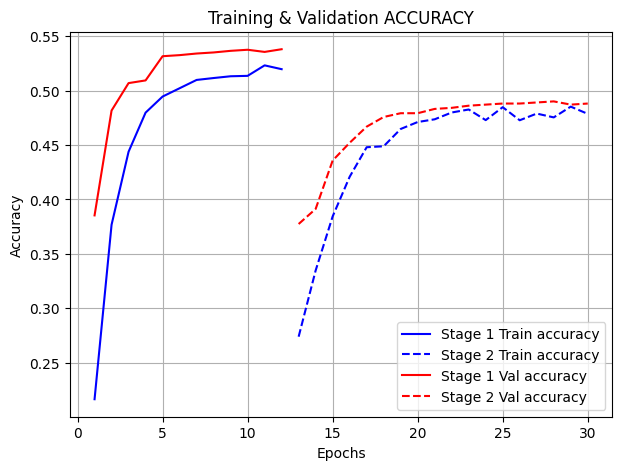

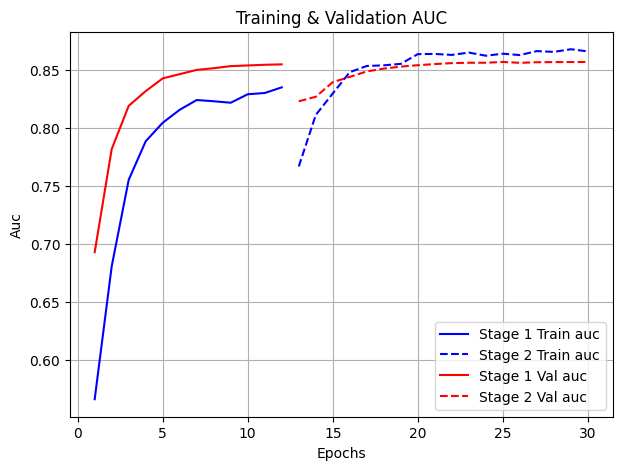

In [48]:
# -----------------------------
# 41. FUNCTION TO PLOT TRAINING CURVES
# -----------------------------

import matplotlib.pyplot as plt

def plot_training_curves(history1, history2, metrics=["loss", "accuracy", "auc"]):
    """
    Plots Stage 1 and Stage 2 training vs validation curves.
    Args:
        history1: Training history from Stage 1
        history2: Training history from Stage 2
        metrics: List of metrics to plot (loss, accuracy, auc)
    """
    # Get history dictionaries for both stages
    hist1 = history1.history
    hist2 = history2.history

    # Epoch counts for Stage 1 & Stage 2
    n1 = len(hist1["loss"])
    n2 = len(hist2["loss"])

    # Loop through each metric and plot separately
    for metric in metrics:
        plt.figure(figsize=(7,5))

        # Training curves
        plt.plot(range(1, n1+1), hist1[metric], 'b-', label=f"Stage 1 Train {metric}")
        plt.plot(range(n1+1, n1+n2+1), hist2[metric], 'b--', label=f"Stage 2 Train {metric}")

        # Validation curves
        plt.plot(range(1, n1+1), hist1[f"val_{metric}"], 'r-', label=f"Stage 1 Val {metric}")
        plt.plot(range(n1+1, n1+n2+1), hist2[f"val_{metric}"], 'r--', label=f"Stage 2 Val {metric}")

        # Formatting
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.title(f"Training & Validation {metric.upper()}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the plotting function
plot_training_curves(history_stage1, history_stage2, metrics=["loss", "accuracy", "auc"])

# What to Look For:
#	•	Loss should decrease steadily.
#	•	Accuracy & AUC should increase.
#	•	If validation metrics drop while training metrics improve → model is overfitting.

In [49]:
# -----------------------------
# 42. LOAD AND PREPROCESS SINGLE IMAGE
# -----------------------------

def load_and_preprocess(img_path):
    """
    Loads and prepares a single image for prediction.
    """
    # Read image from disk
    raw = tf.io.read_file(img_path)
    raw = tf.image.decode_jpeg(raw, channels=3)

    # Resize image to model input size
    raw = tf.image.resize(raw, [IMG_SIZE, IMG_SIZE])

    # Preprocess for EfficientNet
    x = tf.keras.applications.efficientnet.preprocess_input(tf.expand_dims(raw, 0))

    return raw, x

In [50]:
# -----------------------------
# 43. PREDICT SINGLE IMAGE CLASS
# -----------------------------

def predict_image(img_path, model, return_all=False):
    """
    Predicts the class of a single image using the trained model.
    """
    # Preprocess image
    raw, x = load_and_preprocess(img_path)

    # Get prediction probabilities
    probs = model(x, training=False).numpy()[0]

    # Find the class with highest probability
    pred_idx = int(np.argmax(probs))
    result = {
        "label": CLASS_NAMES[pred_idx],
        "probability": float(probs[pred_idx])
    }

    # Optionally return all class probabilities
    if return_all:
        result["all_probs"] = {c: float(probs[i]) for i, c in enumerate(CLASS_NAMES)}

    return result

# Test the model on a sample image from the dataset
result = predict_image(
    "/content/ham10000/HAM10000_images/ISIC_0028579.jpg", # Provide image from the dataset that you want to predict. You can also upload a new image and ask the model to predict
    model
)
print(result)

{'label': 'nv', 'probability': 0.40878134965896606}


In [51]:
# -----------------------------
# 44. PREPROCESS IMAGE FOR MODEL EXPLAINABILITY
# -----------------------------

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def preprocess_for_model(img_tensor):
    """
    Ensures image is in correct format for EfficientNet visualization.
    """
    # Convert to float32 if not already
    if img_tensor.dtype != tf.float32:
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)

    # Resize and preprocess for EfficientNet
    img_tensor = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
    x = tf.keras.applications.efficientnet.preprocess_input(img_tensor * 255.0)

    return tf.expand_dims(x, 0)  # Add batch dimension (1, H, W, 3)

In [52]:
# Occlusion Sensitivity (Explainability)
# This method slides a mask over parts of the image to see which regions affect the prediction most.
# -----------------------------
# 45. OCCLUSION SENSITIVITY HEATMAP
# -----------------------------

def occlusion_sensitivity(img_path, model, patch=32, stride=16, baseline='gray'):
    """
    Visualizes which parts of the image affect model predictions most.
    Args:
        patch: Size of occlusion square.
        stride: How much we slide at each step.
        baseline: 'gray' or 'mean' pixel fill.
    """

    # Read and resize image
    raw = tf.io.read_file(img_path)
    raw = tf.image.decode_jpeg(raw, channels=3)
    raw = tf.image.resize(raw, [IMG_SIZE, IMG_SIZE])
    raw_np = raw.numpy().astype(np.float32) / 255.0

    # Define baseline fill color
    if baseline == 'mean':
        fill = float(np.mean(raw_np))
        fill_patch = np.ones((patch, patch, 3), dtype=np.float32) * fill
    else:
        fill_patch = np.ones((patch, patch, 3), dtype=np.float32) * 0.5

    # Original prediction
    x0 = preprocess_for_model(raw)
    probs0 = model(x0, training=False).numpy()[0]
    cls = int(np.argmax(probs0))
    p0 = float(probs0[cls])

    H = W = IMG_SIZE
    heat = np.zeros((H, W), dtype=np.float32)

    # Slide a patch across the image
    img_work = raw_np.copy()
    for y in range(0, H - patch + 1, stride):
        for x in range(0, W - patch + 1, stride):
            # Mask part of the image
            img_work[y:y+patch, x:x+patch, :] = fill_patch
            x_occ = preprocess_for_model(tf.convert_to_tensor(img_work))
            p_occ = float(model(x_occ, training=False).numpy()[0][cls])
            drop = max(0.0, p0 - p_occ)  # Drop in probability
            heat[y:y+patch, x:x+patch] = np.maximum(heat[y:y+patch, x:x+patch], drop)
            # Restore original region
            img_work[y:y+patch, x:x+patch, :] = raw_np[y:y+patch, x:x+patch, :]

    # Normalize heatmap to 0..1
    if heat.max() > 0:
        heat = heat / heat.max()

    # Colorize heatmap using OpenCV
    heat_u8 = np.uint8(255 * heat)
    cmap = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cmap, 0.35, (raw_np*255).astype(np.uint8), 0.65, 0)

    # Show results
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(raw_np); plt.axis('off')
    plt.subplot(1,3,2); plt.title(f"Occlusion Heatmap\n(class={CLASS_NAMES[cls]})"); plt.imshow(heat, vmin=0, vmax=1); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis('off')
    plt.show()

    return {"pred_label": CLASS_NAMES[cls], "pred_prob": p0, "heatmap": heat}

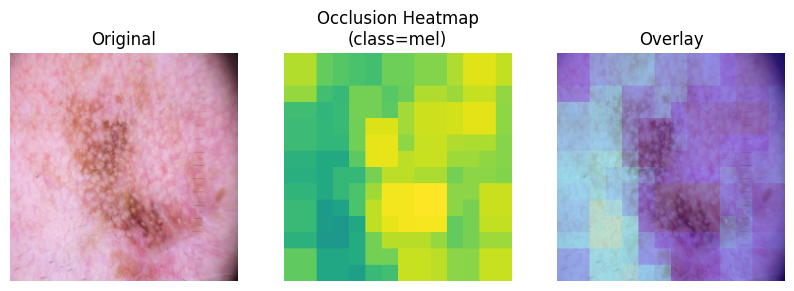

{'pred_label': 'mel', 'pred_prob': 1.0}


In [53]:
# -----------------------------
# 46. RUN OCCLUSION SENSITIVITY
# -----------------------------

img_path = "/content/ham10000/HAM10000_images/ISIC_0030417.jpg"

occlusion_result = occlusion_sensitivity(
    img_path,
    model,
    patch=32,       # Smaller = finer heatmap, slower; Larger = coarser, faster
    stride=16,      # How fast we slide across the image
    baseline='gray' # Fill occluded areas with gray
)

print({k: occlusion_result[k] for k in ["pred_label", "pred_prob"]})